#Install Necessary Libraries

In [1]:
!pip -q install tensorflow_similarity

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.2/207.2 KB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.4/13.4 MB 54.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.2/88.2 KB 6.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.5/188.5 KB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 30.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [2]:
! pip install tensorflow_addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 16.0 MB/s eta 0:00:00


---
#Import Necessary Packages

In [3]:
import tensorflow as tf
import tensorflow_similarity as tfsim 
from tensorflow import keras
import numpy as np
import cv2
import matplotlib.pyplot as plt
from keras.layers import Input, Flatten, Conv2D, MaxPool2D, Dense, BatchNormalization
from keras.optimizers import Adam
from keras import Model
import tensorflow_datasets as tfds
import tensorflow_addons as tfa
from sklearn.datasets import fetch_lfw_people
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import keras.applications as models
from tensorflow.keras.applications.resnet50 import preprocess_input

---
# Loading dataset and Apply The Preprocessings


In [4]:
#Loading LFW Images(size = 128×128)
face_dataset = fetch_lfw_people(min_faces_per_person = 6, resize = 1.0, slice_ = (slice(60, 188), slice(60, 188)), color = True)

# Number of All Images
number_of_images = len(face_dataset.images)
print('Number of All Images is : ', number_of_images)

# Number of Classes
number_of_classes = len(face_dataset.target_names)
print('Number of Classes is : ', number_of_classes)

Number of All Images is :  5425
Number of Classes is :  311


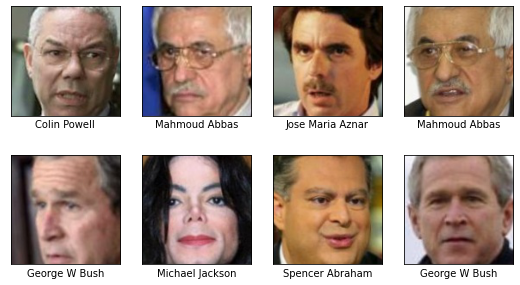

In [5]:
# Display Some Images of Dataset
fig, ax = plt.subplots(2, 4, figsize=(9, 5)) 
for i, axi in enumerate(ax.flat):
    axi.imshow(face_dataset.images[i] / 255) 
    axi.set(xticks=[], yticks=[], xlabel=face_dataset.target_names[face_dataset.target[i]])

In [6]:
#Solving The Imbalanced Data Problem By Determine The Maximum Number of Classes For Each Person (max = 100)

mask = np.zeros(face_dataset.target.shape, dtype=bool)
 
for target in np.unique(face_dataset.target):
    mask[np.where(face_dataset.target == target)[0][:100]] = 1
 
x_face_dataset = face_dataset.data[mask]
y_face_dataset = face_dataset.target[mask]
x_face_dataset = np.reshape(x_face_dataset, (x_face_dataset.shape[0], face_dataset.images.shape[1], face_dataset.images.shape[2], face_dataset.images.shape[3]))
print('Modified Number of Images is : ', x_face_dataset.shape[0])

Modified Number of Images is :  4785


In [7]:
#Resize The Images To (48,48,3)
x_face_dataset_resized = np.zeros((x_face_dataset.shape[0],48,48,3))
for i in range(x_face_dataset.shape[0]):
    x_face_dataset_resized[i,:,:,:] = cv2.resize(x_face_dataset[i,:,:,:], (48,48), interpolation = cv2.INTER_AREA)
print('New Size of Images is :  ', x_face_dataset_resized.shape)

New Size of Images is :   (4785, 48, 48, 3)


In [8]:
#Preprocessing The Images and One-Hot Encoding The Labels

face_images = preprocess_input(np.array(x_face_dataset_resized))
face_labels = to_categorical(y_face_dataset)

In [9]:
#Splitting The Data To Train and Test
x_train, x_test, y_train, y_test = train_test_split(face_images, y_face_dataset, train_size=0.8, stratify=y_face_dataset, random_state=0)
print('Size of Training Images is : ', x_train.shape, '\nSize of Testing Imges is : ', x_test.shape)

Size of Training Images is :  (3828, 48, 48, 3) 
Size of Testing Imges is :  (957, 48, 48, 3)


>> **MultishotMemorySampler**

In [10]:
#Using A Sampler To Ensure That Each Batch Contains At Least N Samples For Each Class Included In A Batch

ms_classes_per_batch = number_of_classes
ms_examples_per_class_per_batch = 5 

train_data = tfsim.samplers.MultiShotMemorySampler(x_train, y_train, classes_per_batch= ms_classes_per_batch,
    examples_per_class_per_batch=ms_examples_per_class_per_batch, class_list=list(y_train))

test_data = tfsim.samplers.MultiShotMemorySampler(x_test, y_test, classes_per_batch= ms_classes_per_batch,
    total_examples_per_class = ms_examples_per_class_per_batch, class_list=list(y_test))


The initial batch size is 1555 (311 classes * 5 examples per class) with 0 augmenters


filtering examples:   0%|          | 0/3828 [00:00<?, ?it/s]

selecting classes:   0%|          | 0/311 [00:00<?, ?it/s]

gather examples:   0%|          | 0/3828 [00:00<?, ?it/s]

indexing classes:   0%|          | 0/3828 [00:00<?, ?it/s]


The initial batch size is 622 (311 classes * 2 examples per class) with 0 augmenters


filtering examples:   0%|          | 0/957 [00:00<?, ?it/s]

selecting classes:   0%|          | 0/311 [00:00<?, ?it/s]

gather examples:   0%|          | 0/1555 [00:00<?, ?it/s]

indexing classes:   0%|          | 0/1555 [00:00<?, ?it/s]

---
# **Define and Compile and Train the Model**

In [23]:
#Defining Model

inputs = Input(shape=(48, 48, 3))
x = tf.keras.layers.experimental.preprocessing.Rescaling(1 / 255)(inputs)

x = Conv2D(64, 3, activation="relu")(inputs)
x = BatchNormalization()(x)
x = MaxPool2D()(x)

x = Conv2D(128, 3, activation="relu")(x)
x = BatchNormalization()(x)
x = MaxPool2D()(x)

x = Conv2D(256, 3, activation="relu")(x)
x = BatchNormalization()(x)
x = MaxPool2D()(x)

x = Flatten()(x)

outputs = tfsim.layers.MetricEmbedding(256)(x)

triplet_model = tfsim.models.SimilarityModel(inputs, outputs)

triplet_model.summary()

Model: "similarity_model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 48, 48, 3)]       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 46, 46, 64)        1792      
                                                                 
 batch_normalization_3 (Batc  (None, 46, 46, 64)       256       
 hNormalization)                                                 
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 23, 23, 64)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 21, 21, 128)       73856     
                                                                 
 batch_normalization_4 (Batc  (None, 21, 21, 128

In [24]:
#loss=tfa.losses.TripletSemiHardLoss()
#loss= tfa.losses.TripletSemiHardLoss()
#loss = tfa.losses.triplet_semihard_loss(y_true, y_pred, distance_metric="L2")

In [25]:
%%time
lr = 0.0001
epochs = 5

#Similarity Loss
loss = tfsim.losses.TripletLoss()

#Compiling Model
triplet_model.compile(optimizer=keras.optimizers.Adam(lr), loss=loss)

#Training Model
history = triplet_model.fit(train_data, epochs=epochs, validation_data=test_data)

Distance metric automatically set to cosine use the distance arg to override.
Epoch 1/5
1000/1000 [==============================] - 416s 415ms/step - loss: 0.5072 - val_loss: 0.5684
Epoch 2/5
1000/1000 [==============================] - 417s 417ms/step - loss: 0.2252 - val_loss: 0.5677
Epoch 3/5
1000/1000 [==============================] - 412s 412ms/step - loss: 0.1615 - val_loss: 0.5652
Epoch 4/5
1000/1000 [==============================] - 412s 412ms/step - loss: 0.1309 - val_loss: 0.5659
Epoch 5/5
1000/1000 [==============================] - 414s 414ms/step - loss: 0.1122 - val_loss: 0.5664
CPU times: user 40min 24s, sys: 39.7 s, total: 41min 4s
Wall time: 35min 22s


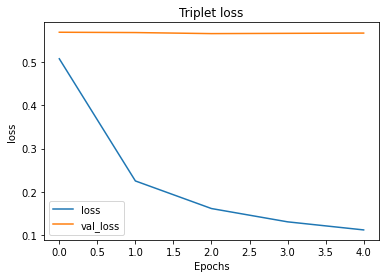

In [26]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.legend(["loss", "val_loss"])
plt.title("Triplet loss")
plt.xlabel("Epochs")
plt.ylabel("loss")
plt.show()

---
# **Indexing**

In [27]:
#Indexing more examples per class will help increase the accuracy/generalization,
# as having more variations improves the classifier "knowledge" of what variations to expect.

index_size = 1555
begin = 0
index_x, index_y = test_data.get_slice(begin, index_size)
triplet_model.reset_index()
triplet_model.index(index_x , index_y, data=index_x)

[Indexing 1555 points]
|-Computing embeddings
49/49 [==============================] - 0s 4ms/step
|-Storing data points in key value store
|-Adding embeddings to index.
|-Building index.


---
# **KNN**

In [28]:
#Implement KNN with Calibration

calibration = triplet_model.calibrate(
    x_test,
    y_test,
    calibration_metric="f1",
    matcher="match_nearest",
    extra_metrics=["precision", "recall", "binary_accuracy"],
    verbose=1,
)

30/30 [==============================] - 0s 4ms/step

Performing NN search



Building NN list:   0%|          | 0/957 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]


 name        value    distance    precision    recall    binary_accuracy        f1
-------  --------  ----------  -----------  --------  -----------------  --------
optimal  0.967571    0.699097     0.981208  0.954308           0.763845  0.967571


# **Embeddings in UMAP**

In [29]:
y_test_listed = y_test.tolist()
new_sorted_test = sorted(set(y_test_listed), key = lambda ele: y_test_listed.count(ele), reverse=True)

masked_test = np.zeros(y_test.shape, dtype=bool) 
num_examples_to_clusters = 5
for target in range(num_examples_to_clusters):
    masked_test[np.where(y_test == new_sorted_test[target])[0][:5]] = 1

new_vx_test = x_test[masked_test]
new_vy_test = y_test[masked_test]

thumb_size = 100
plot_size = 400
tfsim.visualization.projector(
    triplet_model.predict(new_vx_test), labels=new_vy_test, images=new_vx_test, image_size=thumb_size, plot_size=plot_size, pt_size=8)

1/1 [==============================] - 0s 21ms/step
perfoming projection using UMAP


generating diplayabe images:   0%|          | 0/25 [00:00<?, ?it/s]

In [30]:
y_train_listed = y_train.tolist()
new_sorted_train = sorted(set(y_train_listed), key = lambda ele: y_train_listed.count(ele), reverse=True)

masked_train = np.zeros(y_train.shape, dtype=bool) 
num_examples_to_clusters = 5
for target in range(num_examples_to_clusters):
    masked_train[np.where(y_train == new_sorted_train[target])[0][:5]] = 1

new_vx_train = x_train[masked_train]
new_vy_train = y_train[masked_train]

thumb_size = 100
plot_size = 400
tfsim.visualization.projector(
    triplet_model.predict(new_vx_train), labels=new_vy_train, images=new_vx_train, image_size=thumb_size, plot_size=plot_size, pt_size=8)

1/1 [==============================] - 0s 48ms/step
perfoming projection using UMAP


generating diplayabe images:   0%|          | 0/25 [00:00<?, ?it/s]